In [31]:
import pandas as pd
import numpy as np
import pymssql  
import requests as re
import json
import geopandas as gpd
from shapely import geometry
from matplotlib import pyplot as plt
import os

#  2 generation_shapefile

In [ ]:
ms=pd.read_csv(r'station_coding.csv',encoding='utf-8')
print(ms.shape)

In [ ]:
gs=pd.read_csv(r'station_gps.csv',encoding='utf-8')
print(gs.shape)

In [39]:
gs.drop_duplicates(subset=['station'], keep='first', inplace=True)
gs.shape

(326, 6)

In [47]:
print(gs.shape)
bc=[['none','none','Gucheng','116.184210997','39.9061758','METRO'],
 ['none','none','Gaojiayuan','116.482484','39.979314','METRO'],
 ['none','none','lingjinghutong','116.36752','39.9145247','METRO'],
 ['none','none','Taoranqiao','116.380933','39.8673939','METRO']]
for i in bc:
    gs.loc[int(gs.shape[0])+1]=i
print(gs.shape)

(326, 6)
(330, 6)


#  2.1 station_shapefile

In [48]:
sts_all=list(set(list(ms['station'])))

In [ ]:
lngs=[]
lats=[]
s=[]
for i in sts_all:
    if gs[gs['station']==i].shape[0]>=1:
        lngs.append(float(list(gs[gs['station']==i]['lng'])[0]))
        lats.append(float(list(gs[gs['station']==i]['lat'])[0]))
        s.append(i)
sts_=pd.DataFrame()
sts_['station']=s
sts_['lng']=lngs
sts_['lat']=lats

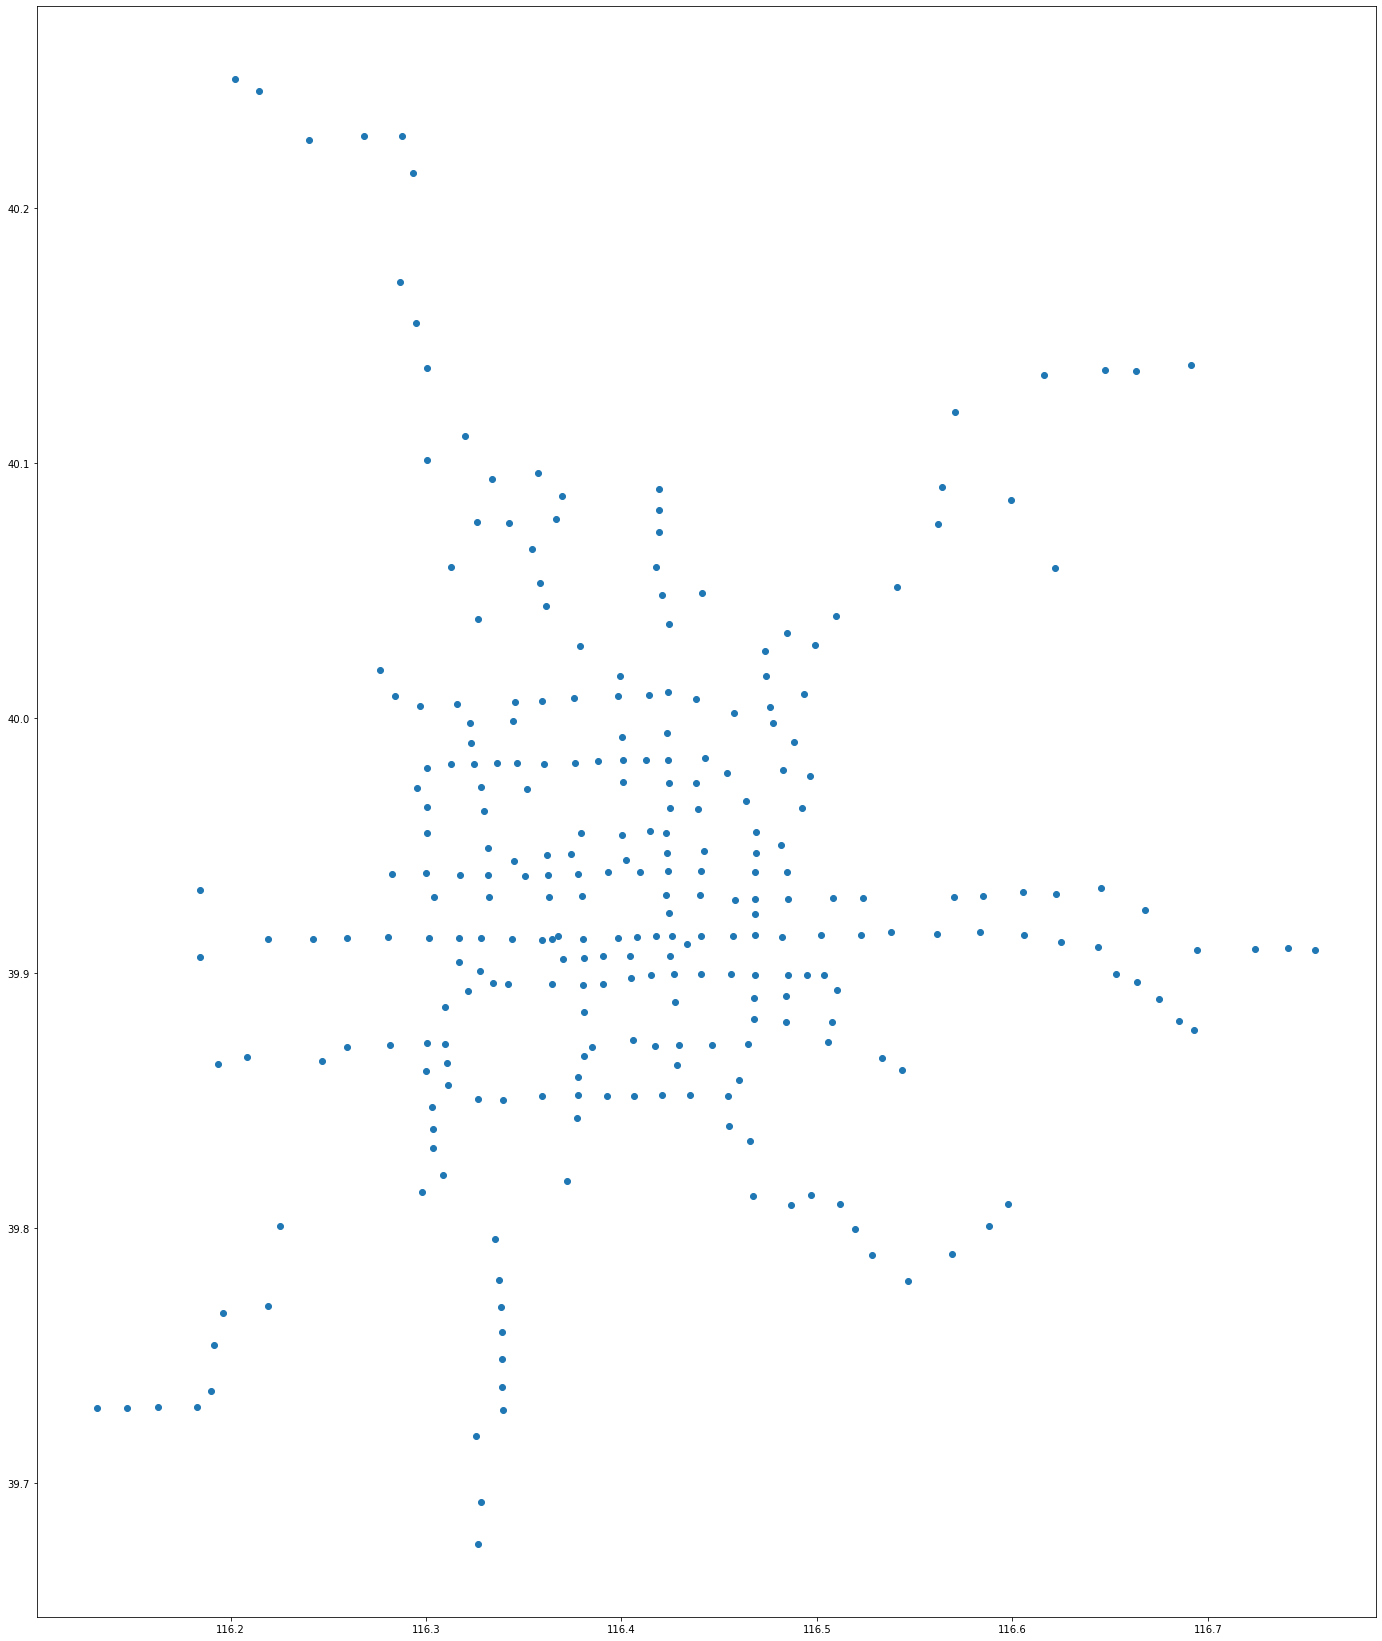

In [50]:
ss_shp = gpd.GeoDataFrame(sts_[['station','lng','lat']],
                          geometry=gpd.points_from_xy(sts_['lng'],sts_['lat'],crs='epsg:4326'))
ss_shp.plot(figsize=(24,32))
plt.show()
ss_shp.to_file(r'shapefile\subway_station.shp',driver='ESRI Shapefile',encoding='utf-8')

In [51]:
print(len(list(set(list(ms['station_name'])))))
print(sts_.shape)

287
(282, 3)


In [52]:
ms_s=list(set(list(ms['station_name'])))
for i in ms_s:
    if i not in list(sts_['station']):
        print(i)

14待开通4
14待开通5
14待开通2
14待开通3
14待开通1


In [53]:
print(ms.shape)
ms=ms[ms['站名']!='14待开通1']
ms=ms[ms['站名']!='14待开通2']
ms=ms[ms['站名']!='14待开通3']
ms=ms[ms['站名']!='14待开通4']
ms=ms[ms['站名']!='14待开通5']
print(ms.shape)

(343, 5)
(338, 5)


#  2.2 地铁线路的shape

In [54]:
ms.head()

,线路名,线路,站码,Label,站名
0,1号线,1,3,103,苹果园
1,1号线,1,4,104,古城路
2,1号线,1,5,105,八角游乐园
3,1号线,1,6,106,八宝山
4,1号线,1,7,107,玉泉路


In [56]:
lines=list(set(list(ms['线路名'])))

In [84]:
li_all=[]
cq=[]
for i in lines:
    ms_i=ms[ms['线路名']==i].sort_values(by=['站码'])
    ms_i.drop_duplicates(subset=['站名'], keep='first', inplace=True)
    li_s=list(ms_i['站名'])
    li_all.append(li_s)
    cq.append(geometry.LineString([(list(sts_[sts_['station']==i]['lng'])[0],list(sts_[sts_['station']==i]['lat'])[0]) for i in li_s]))
df_line=pd.DataFrame()
df_line['line']=lines
df_line['stations']=li_all
df_line['geometry']=cq
df_line.head()

,line,stations,geometry
0,9号线,"[国家图书馆, 白石桥南, 白堆子, 军事博物馆, 北京西站, 六里桥东, 六里桥, 七里庄...","LINESTRING (116.331897 39.948864, 116.33181 39..."
1,15号线,"[清华东路西口, 六道口, 北沙滩, 奥林匹克公园, 安立路, 关庄, 望京西, 望京, 望...","LINESTRING (116.345527 40.0063, 116.359309 40...."
2,机场线,"[东直门, 三元桥, T3航站楼, T2航站楼]","LINESTRING (116.442359 39.947697, 116.463716 3..."
3,大兴线,"[公益西桥, 新宫, 西红门, 高米店北, 高米店南, 枣园, 清源路, 黄村西大街, 黄村...","LINESTRING (116.377314 39.843056, 116.372097 3..."
4,1号线,"[苹果园, 古城路, 八角游乐园, 八宝山, 玉泉路, 五棵松, 万寿路, 公主坟, 军事博...","LINESTRING (116.184436 39.932436, 116.18421099..."


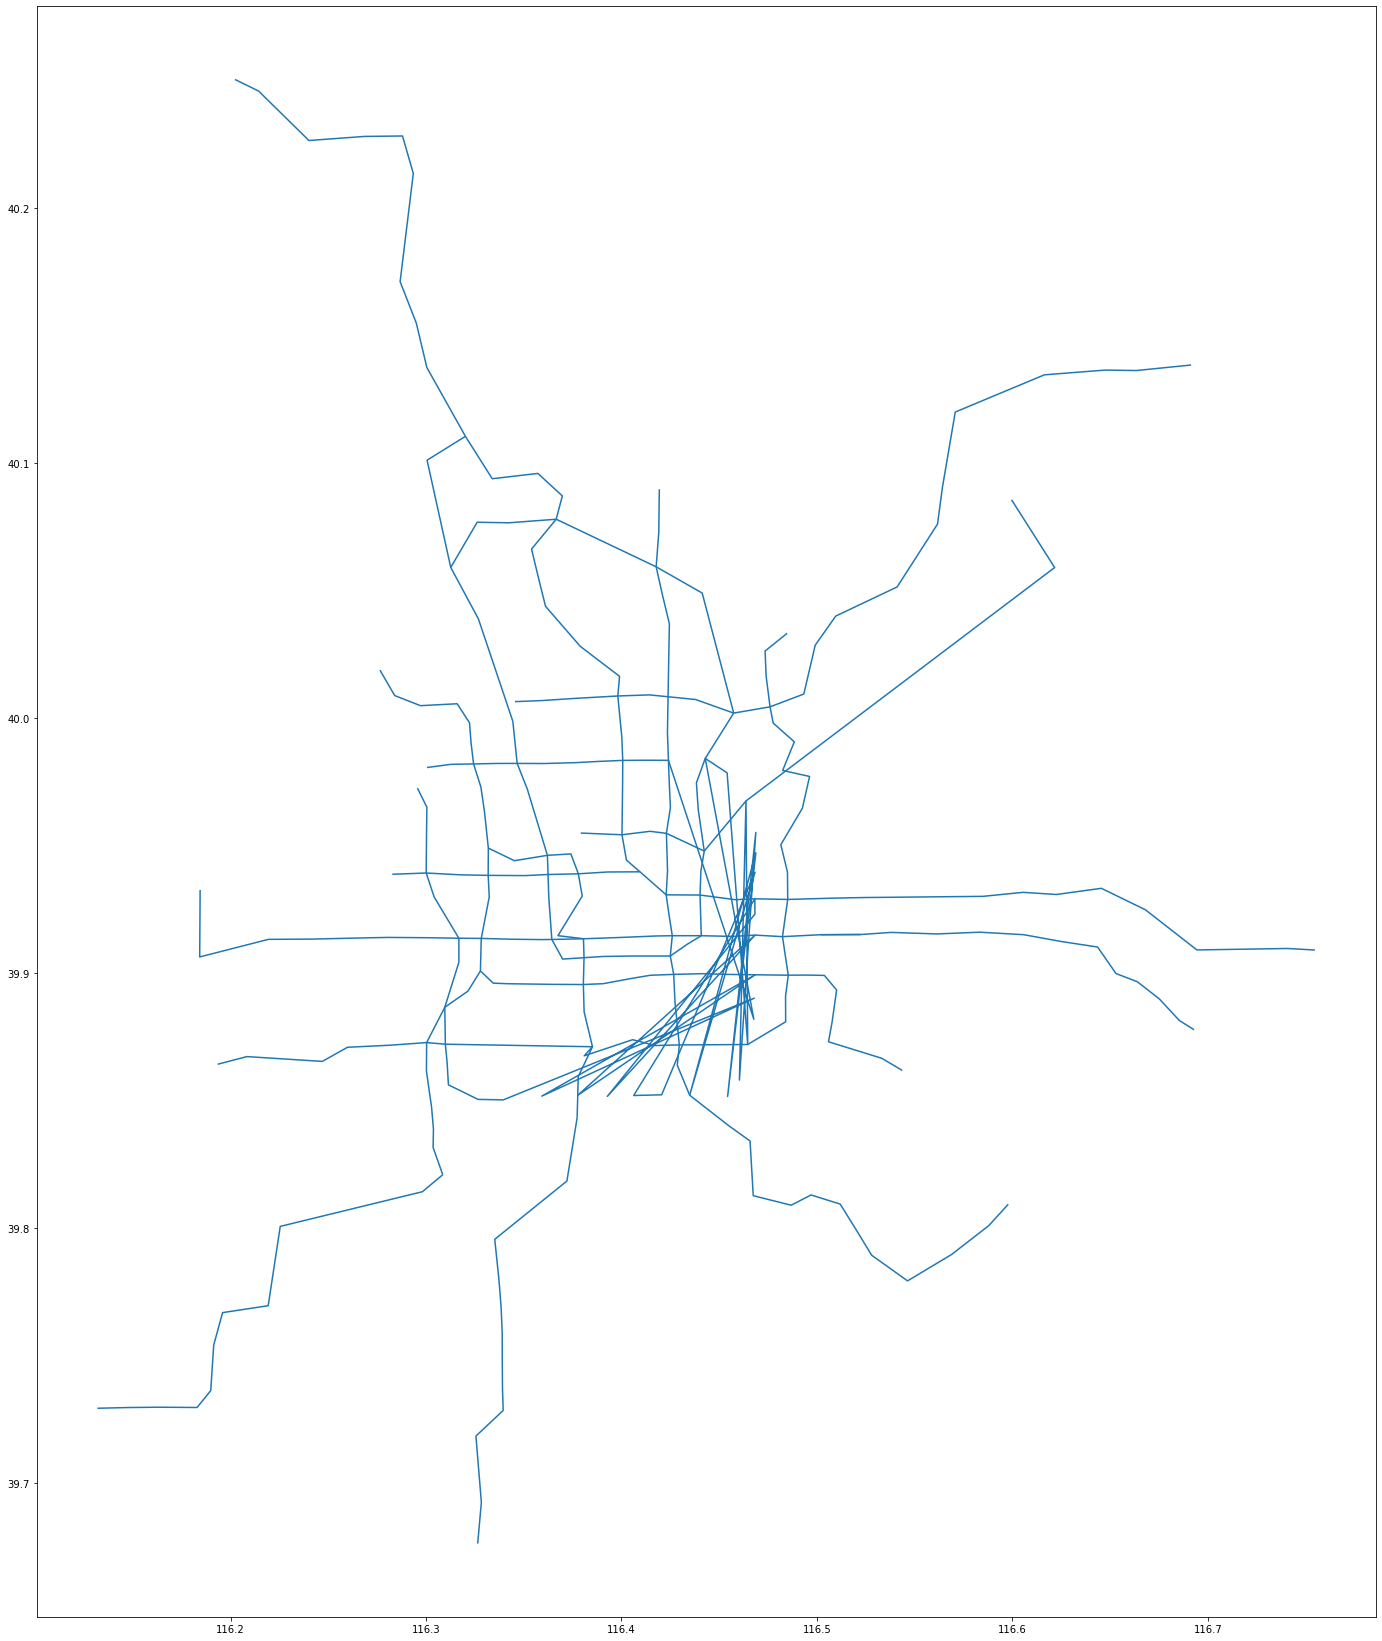

In [85]:
line_shp=gpd.GeoDataFrame(geometry=cq,crs='epsg:4326')
line_shp['line']=lines
line_shp['stations']=li_all
line_shp.plot(figsize=(24,32))
plt.show()

###  2.2 续

In [77]:
cells=pd.read_csv(r'pylearn\station_cells.csv',encoding='gbk')
cells.head()

,Unnamed: 0,line_name,station_cells
0,0,1号线,"['四惠东', '四惠', '大望路', '国贸', '永安里', '建国门', '东单',..."
1,1,2号线,"['积水潭', '鼓楼大街', '安定门', '雍和宫', '东直门', '东四十条', '..."
2,2,4号线,"['安河桥北', '北宫门', '西苑', '圆明园', '北京大学东门', '中关村', ..."
3,3,5号线,"['天通苑北', '天通苑', '天通苑南', '立水桥', '立水桥南', '北苑路北',..."
4,4,6号线,"['潞城', '东夏园', '郝家府', '北运河西', '通州北关', '物资学院路', ..."


In [78]:
def split_x(x):
    return x.replace('[','').replace(']','').replace(' ','').replace("'",'').split(',')
cells['station_cells']=cells['station_cells'].apply(lambda x:split_x(x))
cells.head(1)

,Unnamed: 0,line_name,station_cells
0,0,1号线,"[四惠东, 四惠, 大望路, 国贸, 永安里, 建国门, 东单, 王府井, 天安门东, 天安..."


In [81]:
stc=[]
for i in range(cells.shape[0]):
    stc.extend(cells.iloc[i,2])
for i in stc:
    if i not in list(sts_['station']):
        print(i)

古城
灵境胡同
安德里北街
3号航站楼
2号航站楼


In [96]:
for i in range(cells.shape[0]):
    lt_i=cells.iloc[i,2]
    if '古城' in cells.iloc[i,2]:
        lt_i[int(lt_i.index('古城'))]='古城路'
    if '灵境胡同' in cells.iloc[i,2]:
        lt_i[int(lt_i.index('灵境胡同'))]='灵镜胡同'
    if '3号航站楼' in cells.iloc[i,2]:
        lt_i[int(lt_i.index('3号航站楼'))]='T3航站楼'
    if '2号航站楼' in cells.iloc[i,2]:
        lt_i[int(lt_i.index('2号航站楼'))]='T2航站楼'
    if '安德里北街' in cells.iloc[i,2]:
        del lt_i[int(lt_i.index('安德里北街'))]
    cells.loc[i]=[cells.iloc[i,0],cells.iloc[i,1],lt_i]
cells.head()

C:\Users\111\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,Unnamed: 0,line_name,station_cells
0,0,1号线,"[四惠东, 四惠, 大望路, 国贸, 永安里, 建国门, 东单, 王府井, 天安门东, 天安..."
1,1,2号线,"[积水潭, 鼓楼大街, 安定门, 雍和宫, 东直门, 东四十条, 朝阳门, 建国门, 北京站..."
2,2,4号线,"[安河桥北, 北宫门, 西苑, 圆明园, 北京大学东门, 中关村, 海淀黄庄, 人民大学, ..."
3,3,5号线,"[天通苑北, 天通苑, 天通苑南, 立水桥, 立水桥南, 北苑路北, 大屯路东, 惠新西街北..."
4,4,6号线,"[潞城, 东夏园, 郝家府, 北运河西, 通州北关, 物资学院路, 草房, 常营, 黄渠, ..."


In [98]:
cells=cells.drop(columns='Unnamed: 0')

In [124]:
li_s=cells[cells['line_name']=='10号线'].iloc[0,1]
ge=geometry.LineString([(list(sts_[sts_['station']==i]['lng'])[0],list(sts_[sts_['station']==i]['lat'])[0]) for i in li_s])
df_line.loc[10]=['10号线',li_s,ge]
df_line.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:881: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  element = np.asarray(element)
C:\Users\111\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:938: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr_value = np.asarray(value)


,line,stations,geometry
0,9号线,"[国家图书馆, 白石桥南, 白堆子, 军事博物馆, 北京西站, 六里桥东, 六里桥, 七里庄...","LINESTRING (116.331897 39.948864, 116.33181 39..."
1,15号线,"[清华东路西口, 六道口, 北沙滩, 奥林匹克公园, 安立路, 关庄, 望京西, 望京, 望...","LINESTRING (116.345527 40.0063, 116.359309 40...."
2,机场线,"[东直门, 三元桥, T3航站楼, T2航站楼]","LINESTRING (116.442359 39.947697, 116.463716 3..."
3,大兴线,"[公益西桥, 新宫, 西红门, 高米店北, 高米店南, 枣园, 清源路, 黄村西大街, 黄村...","LINESTRING (116.377314 39.843056, 116.372097 3..."
4,1号线,"[苹果园, 古城路, 八角游乐园, 八宝山, 玉泉路, 五棵松, 万寿路, 公主坟, 军事博...","LINESTRING (116.184436 39.932436, 116.18421099..."


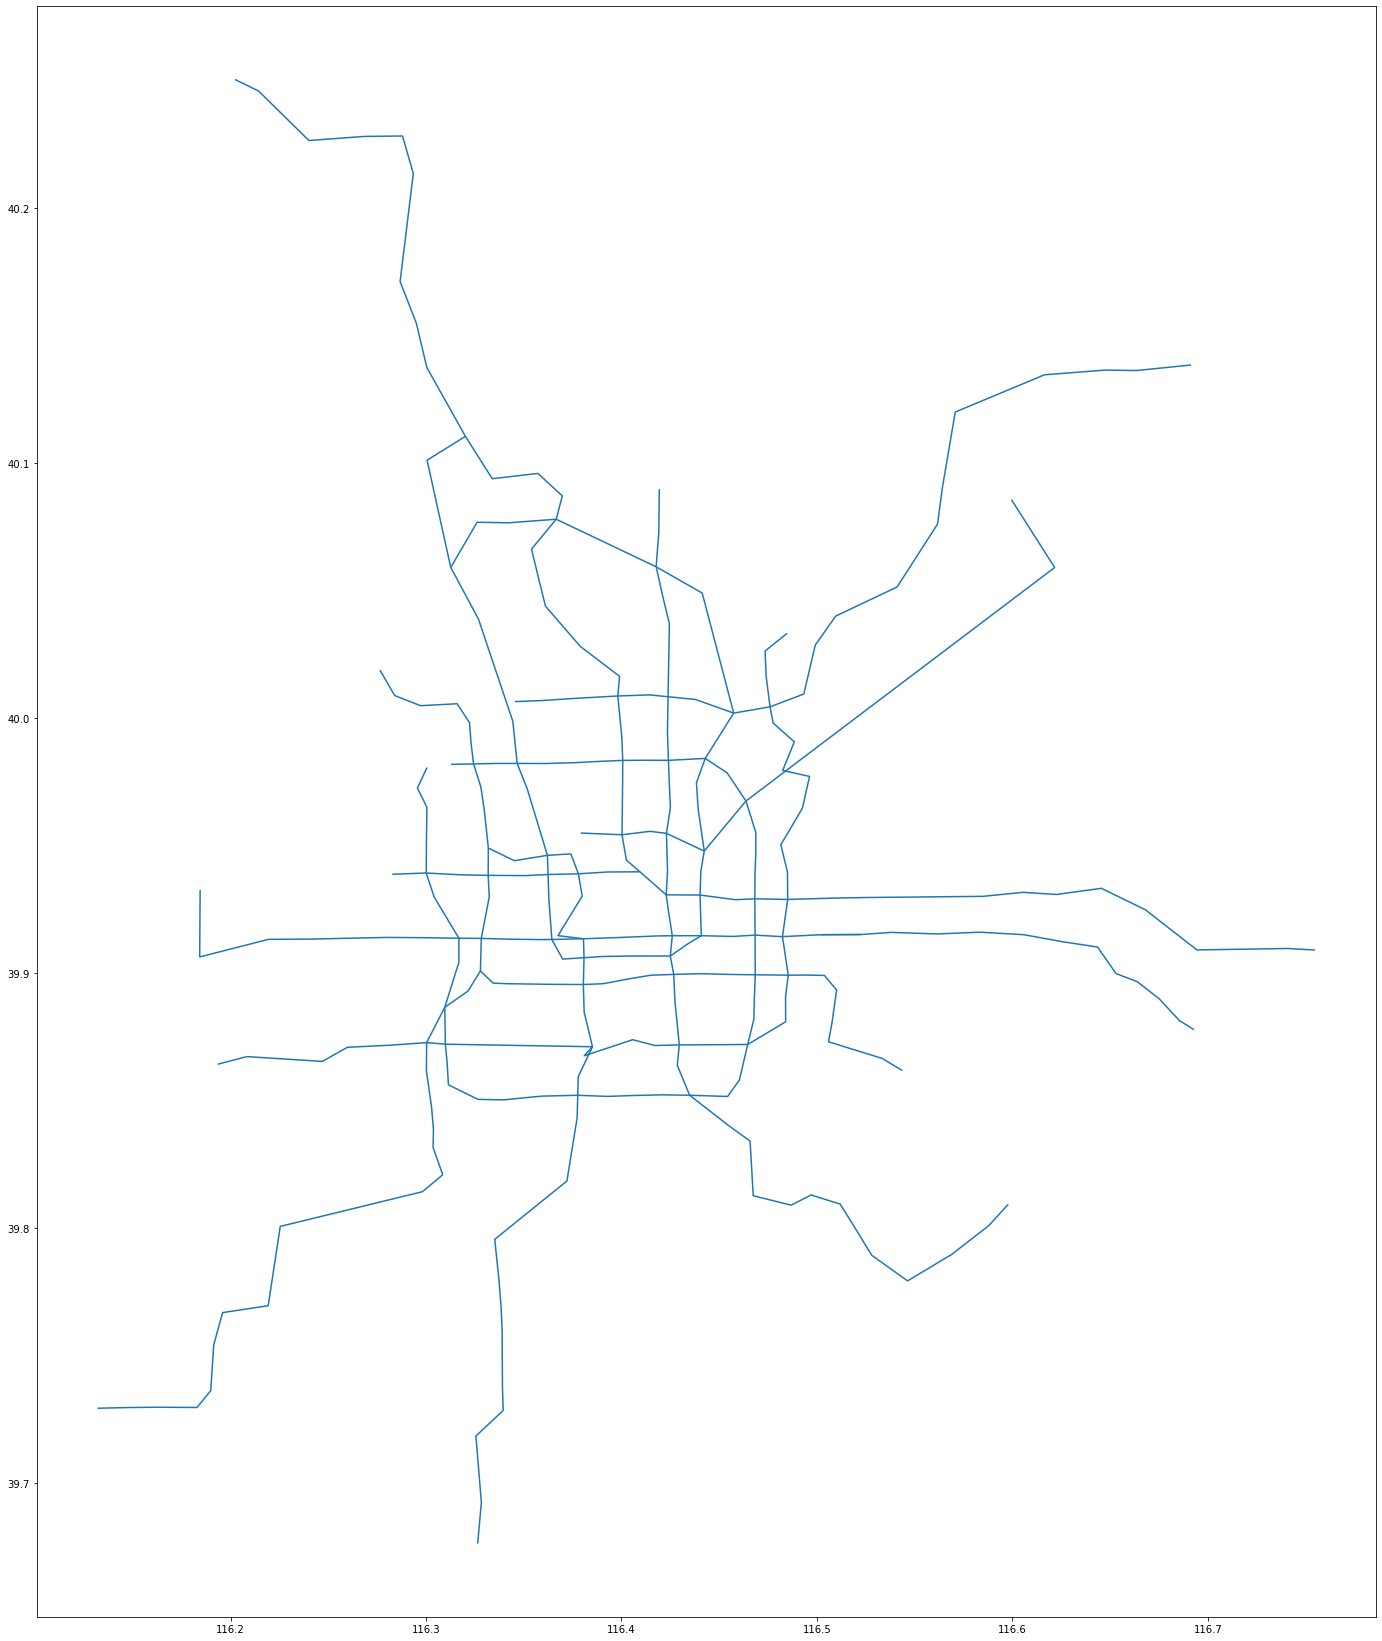

In [141]:
line_shp=gpd.GeoDataFrame(geometry=list(df_line['geometry']),crs='epsg:4326')
line_shp.plot(figsize=(24,32))
plt.show()

##  2.3 环线处理

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:881: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  element = np.asarray(element)
C:\Users\111\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\internals\blocks.py:938: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr_value = np.asarray(value)


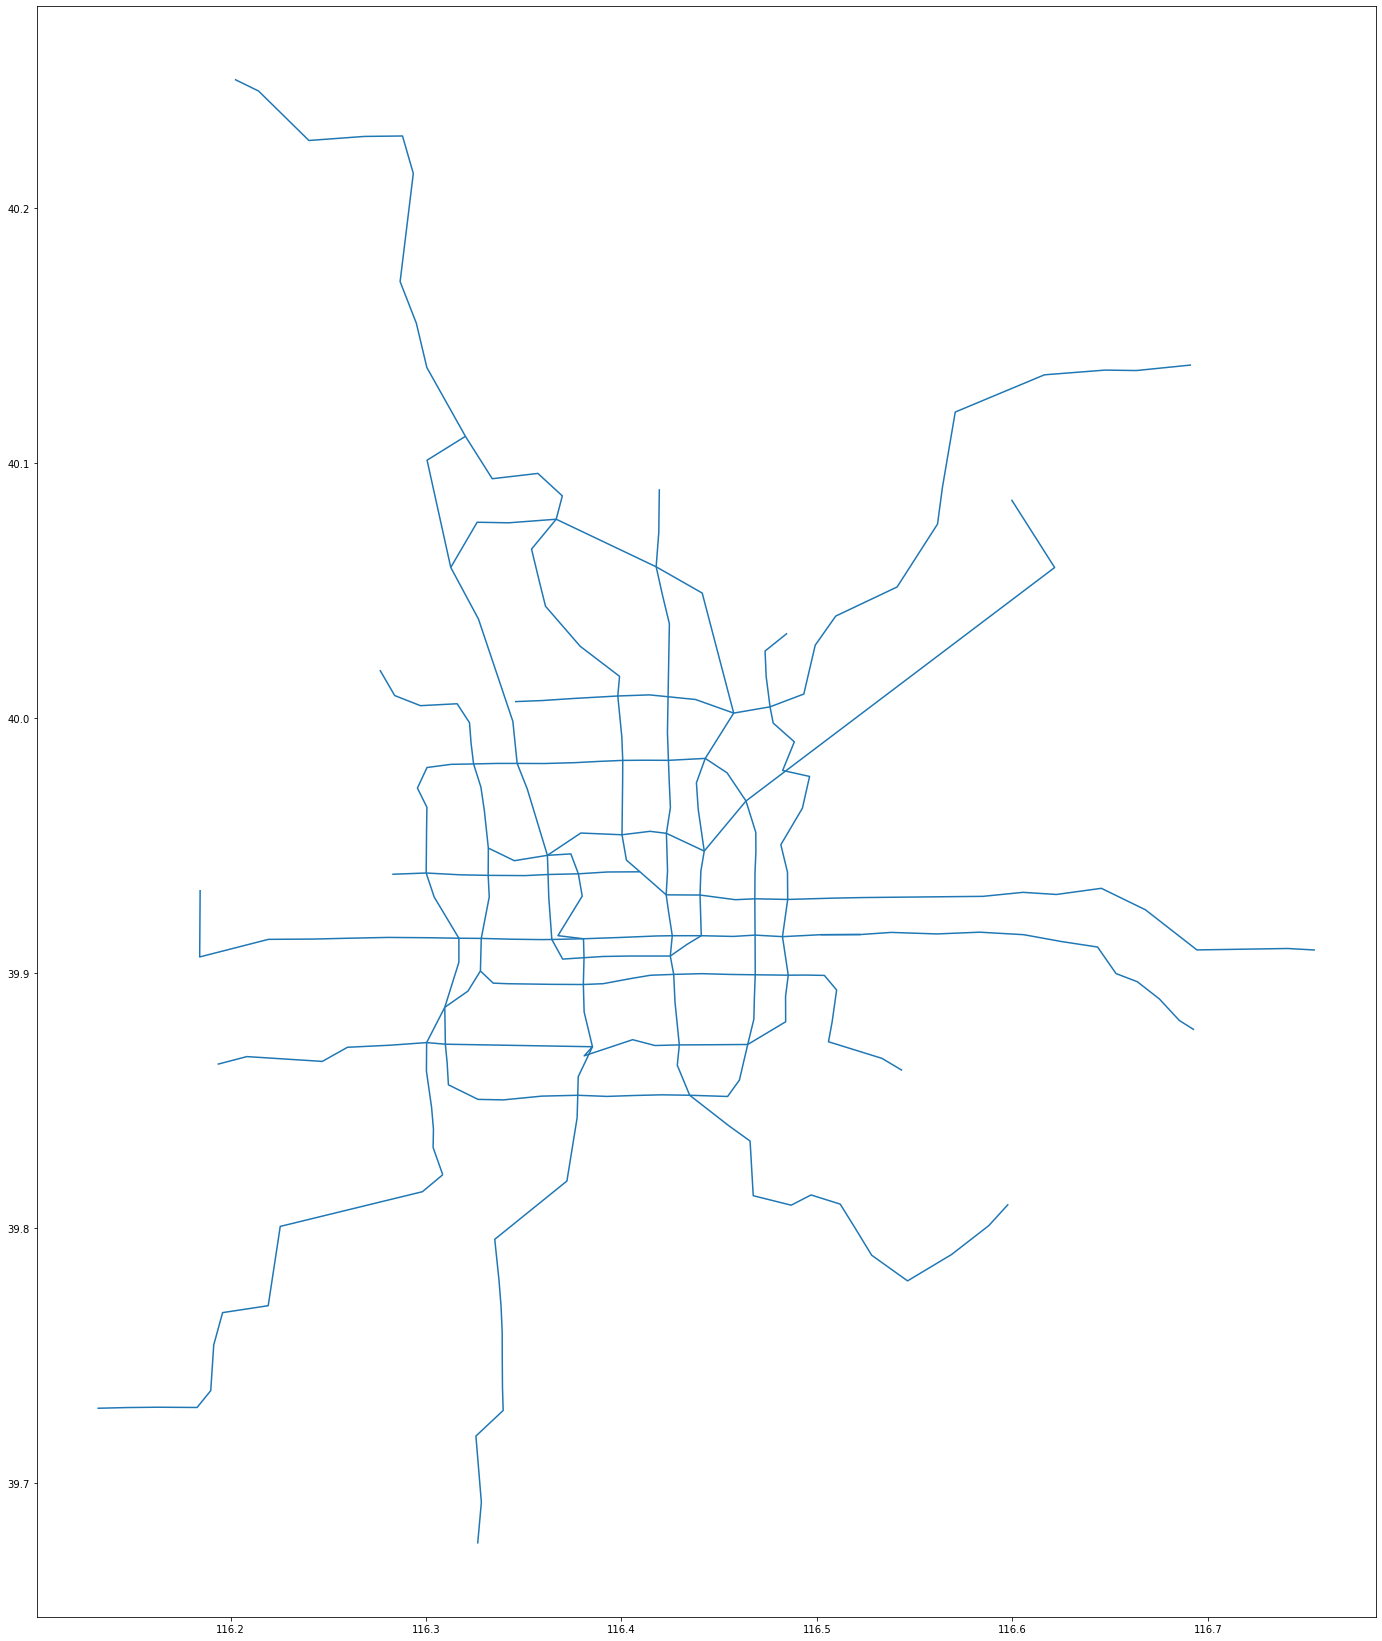

In [143]:
loop_line=['2号线','10号线']
for i in loop_line:
    si=df_line[df_line['line']==i].iloc[0,1]
    si.append(si[0])
    ge=geometry.LineString([(list(sts_[sts_['station']==i]['lng'])[0],list(sts_[sts_['station']==i]['lat'])[0]) for i in si])
    df_line.loc[df_line[df_line['line']==i].index]=[i,si,ge]
line_shp=gpd.GeoDataFrame(geometry=list(df_line['geometry']),crs='epsg:4326')
line_shp.plot(figsize=(24,32))
plt.show()

In [145]:
line_shp['line']=list(df_line['line'])
line_shp['stations']=list(df_line['stations'])

In [147]:
sh01=gpd.read_file(r'shapefile\beij_fq.shp') # 读取全国面域文件

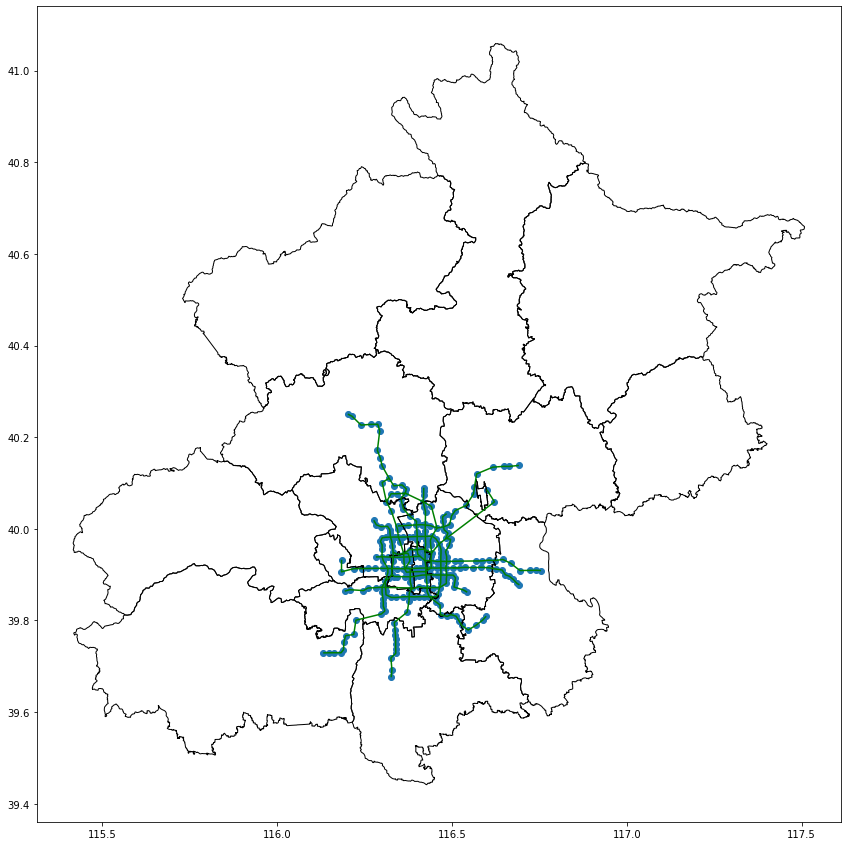

In [148]:
fig,ax = plt.subplots(figsize=(15,15))

ss_shp.plot(ax=ax)
line_shp.plot(ax=ax,color='g')
sh01.plot(ax=ax,facecolor='none',edgecolor='k')
plt.show()

##  3 保存数据

In [149]:
ss_shp.to_file(r'shapefile\subway_station.shp',driver='ESRI Shapefile',encoding='utf-8')

In [151]:
lis=line_shp.copy()
lis['stations']=lis['stations'].apply(lambda x:str(x))

In [152]:
lis.to_file(r'shapefile\subway_line.shp',driver='ESRI Shapefile',encoding='utf-8')

In [154]:
ss_shp.to_csv('地铁站点.csv',encoding='gbk')

In [157]:
line_shp.to_csv('地铁线路.csv',encoding='gbk')